### Imports & Installs

#### Installs

In [ ]:
!pip3 install openml

#### URLs

<a src="https://docs.openml.org/benchmark/">https://docs.openml.org/benchmark/</a><br>
http://rel.liacs.nl/

#### Imports

In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import openml
import sklearn
import pandas as pd

from tqdm import tqdm

from skopt import BayesSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold

%matplotlib inline

### OpenML100

In [ ]:
study_id = 123
tag = 'study_%d' % study_id
study = openml.study.get_study(study_id, 'tasks')

features_dict = {}
targets_dict = {}

for task_id in study.tasks:
    if task_id != 34536: # for whatever reason this one doesn't work
        task = openml.tasks.get_task(task_id)
        features_dict[task_id], targets_dict[task_id] = task.get_X_and_y() 

In [13]:
# type(features_dict[3])
type(targets_dict[3])
# len(targets_dict[3])
datasets_sizes = []
datasets_sizes2 = []

for key in features_dict.keys():
    datasets_sizes.append(features_dict[key].shape[0])
    datasets_sizes2.append(features_dict[key].shape[1])



#### Test other

(array([233.,   1.,   4.,  45.,   2.,   1.,   0.,   4.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   4.,   0.,   2.]),
 array([1.00000e+00, 3.06890e+03, 6.13680e+03, 9.20470e+03, 1.22726e+04,
        1.53405e+04, 1.84084e+04, 2.14763e+04, 2.45442e+04, 2.76121e+04,
        3.06800e+04, 3.37479e+04, 3.68158e+04, 3.98837e+04, 4.29516e+04,
        4.60195e+04, 4.90874e+04, 5.21553e+04, 5.52232e+04, 5.82911e+04,
        6.13590e+04]),
 <BarContainer object of 20 artists>)

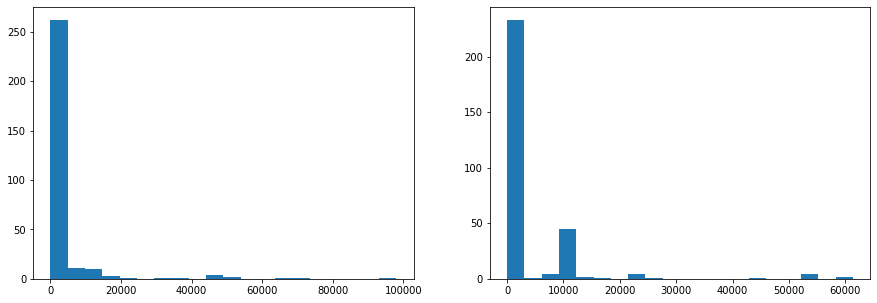

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
# plt.xscale('log')
plt.hist(datasets_sizes, bins=20)

plt.subplot(1,2,2)
# plt.xscale('log')
plt.hist(datasets_sizes2, bins=20)

In [21]:
datasets_sizes2[np.argmax(datasets_sizes2)]

61359

In [24]:
list(features_dict.keys())[165]

3932

In [28]:
features_dict[3932].shape
features_dict[3932].shape

(3196, 36)

In [12]:
benchmark_suite = openml.study.get_suite(suite_id='OpenML100')

In [24]:
features_dict = {}
targets_dict = {}

for task_id in benchmark_suite.tasks:
    if task_id != 34536: # for whatever reason this one doesn't work
        # print(type(task_id))
        task = openml.tasks.get_task(task_id)
        features_dict[task_id], targets_dict[task_id] = task.get_X_and_y() 
        

### OpenML-CC18

In [3]:
benchmark_suite = openml.study.get_suite(suite_id='OpenML-CC18')

datasets = []
print(benchmark_suite, "\n======================")
for dataset_id in benchmark_suite.data:
    data = openml.datasets.get_dataset(dataset_id)
    if len(data.features) < 6: # This skips one huge dataset, but reduces time
        X, y, categorical_indicator, attribute_names = data.get_data(
            dataset_format="array", target=data.default_target_attribute
        )
        df = pd.DataFrame(X, columns=attribute_names)
        df["target"] = y
        df["dataset_id"] = data.id
        datasets.append(df)
    
print(f"{len(datasets)}/{len(benchmark_suite.data)} datasets used")

OpenML Benchmark Suite
ID..............: 99
Name............: OpenML-CC18 Curated Classification benchmark
Status..........: active
Main Entity Type: task
Study URL.......: https://www.openml.org/s/99
# of Data.......: 72
# of Tasks......: 72
Creator.........: https://www.openml.org/u/1
Upload Time.....: 2019-02-21 18:47:13 
4/72 datasets used


In [2]:
# Models
models = [
    # ("DecisionTreeClassifier", DecisionTreeClassifier()),
    ("RandomForestClassifier", RandomForestClassifier()),
    ("SVC", SVC()), 
    # ("NearestNeighbors", NearestNeighbors()),
    # ("LogisticRegression", LogisticRegression()), 
    # ("SGDClassifier", SGDClassifier()), 
    # ("MLPClassifier", MLPClassifier()),
    # ("GaussianNB", GaussianNB())
]

# Hyper parameter spaces for bayesian optimization
hyper_params = {
    "RandomForestClassifier": {
        "n_estimators": (50, 500),
        "max_features": ["auto", "sqrt"],
        "max_depth": (1, 1000),
        "min_samples_split": (2, 10),
        "min_samples_leaf": (1, 10),
        },
    "SVC": {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    }
}

In [6]:
from functions import get_datasets

datasets = get_datasets(random_cnt=2)

In [7]:
results = pd.DataFrame()

for dataset in tqdm(datasets):
    dataset = dataset.dropna(axis=0) # remove nan values
    if len(dataset) < 3: # some datasets are empty after removing nan
        continue
    X, y, id = dataset.drop(["target", "dataset_id"], axis=1), dataset["target"], min(dataset["dataset_id"])
    for name, model in tqdm(models):
        opt = model
        if name in hyper_params: # for now needed, extra hyperparam spaces required
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.72, random_state=42)
            bayesian = BayesSearchCV(model, hyper_params[name], n_iter=50, n_points=4, n_jobs=-1, cv=3) # Takes a long time!
            bayesian = bayesian.fit(X_train, y_train)
            opt = bayesian.best_estimator_
        cv_score_before = cross_val_score(opt, X, y, cv=10)

        # some random feature selection method
        fs_t = ExtraTreesClassifier(n_estimators=50)
        fs_t.fit(X, y)
        fsModel = SelectFromModel(fs_t, prefit=True)
        X = fsModel.transform(X)

        if name in hyper_params: # for now needed, extra hyperparam spaces required
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.72, random_state=42)
            bayesian = BayesSearchCV(model, hyper_params[name], n_iter=50, n_points=32, n_jobs=-1, cv=3) # Takes a long time!
            bayesian = bayesian.fit(X_train, y_train)
            opt = bayesian.best_estimator_
            
        cv_score_after = cross_val_score(opt, X, y, cv=10)

        row = {
            "Dataset_id": id, 
            "model": name, 
            "cv_scores_before": cv_score_before, 
            "cv_scores_after": cv_score_after
        }
        results = results.append(row, ignore_index=True)

0it [00:00, ?it/s]
  0%|          | 0/2 [04:01<?, ?it/s]
0it [04:01, ?it/s]


ValueError: array must not contain infs or NaNs

In [5]:
from time import time

time()

1638372912.8623528

In [77]:
np.set_printoptions(linewidth=10000)
print(results)
results.to_csv("res.csv", index=False)

   Dataset_id                   model  \
0        11.0  RandomForestClassifier   

                                    cv_scores_before  \
0  [0.5238095238095238, 0.746031746031746, 0.5873...   

                                     cv_scores_after  
0  [0.4603174603174603, 0.4603174603174603, 0.460...  
